In [49]:
import numpy as np
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet
from mne.channels import make_standard_montage

# Enable interactive mode for matplotlib
plt.ion()

# special form of print to visualize betterrrrr
def print_section(title):
    """Print a formatted section title"""
    print(f"\n{'='*80}\n{title}\n{'='*80}")
    

<img src="/Users/caetano/Desktop/BACHELOR PROEF/64_channel_sharbrough-old (1).png" width="500">


This image shows the allocation of the different EEG channels on the scalp of all patients / trials

In [50]:

print_section("1. Loading and Initial Setup")

# Parameters
subject_id = 1
runs = [4, 8, 12]  # Motor imagery runs, not every run is included  because now we just want to make some simple analysis and visualisations.

# Downloading  and loading the dataset of PhysioNet
print(f"Downloading data for subject {subject_id}, runs {runs}...")
raw_fnames = eegbci.load_data(subject_id, runs)
raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

# Rename channels to standard naming
eegbci.standardize(raw)

# Print basic information:
#The PhysioNet dataset uses non-standard channel names like 
# 'FC3', 'FC1', 'FCz', etc. On the other hand some channels might be labeled differently
# across different recording systems

# what does  standardisation do? 
# Renames the EEG channels to follow the standard 
# 10-20 international system naming convention
# Ensures consistency across different recordings
print("\nDataset Information:")
print(f"Number of channels: {len(raw.ch_names)}")
print(" ")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(" ")
print(f"Recording duration: {raw.times.max():.2f} seconds")
print(" ")
print(f"Channel names: {raw.ch_names}")


1. Loading and Initial Setup
Extracting EDF parameters from /Users/caetano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/caetano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/caetano/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...

Dataset Information:
Number of channels: 64
 
Sampling frequency: 160.0 Hz
 
Recording duration: 374.99 seconds
 
Channel names: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', '

64 EEG signals so number of channels is 64, each sampled at 160 samples per second. This means that the sample frequency is 160 Hz.

In [51]:
# Add EEG montage information. A montage defines the physical position of EEG electrodes on the head

montage = make_standard_montage('standard_1020')
raw.set_montage(montage)
# Standard_1020 refers to the international 10-20 system of standard electrode placement
print_section("2. Data Preprocessing")

# Apply band-pass filter. Band pass filters are used on the EEG data to keep opnly frequencies between 
# 7 - 30 Hz
# This range includes 
# Mu rhythm (8-12 Hz): important for motor imagery
# Beta band (13-30 Hz): also relevant for motor activity

print("Applying band-pass filter (7-30 Hz)...")
raw_filtered = raw.copy().filter(7., 30., fir_design='firwin')
# the type of filter is firwin which specifies the type of filter:  finite impulse response


# Create events from annotations. It uses events_id which is a dictionary mapping event
# names to numbers. In our case ( for physionet dataset: 
# 'T1': Left hand imagery
# 'T2': Right hand imagery)
print("\nCreating epochs...")
events, event_id = mne.events_from_annotations(raw_filtered)

# Print event information
print("\nEvent IDs found:")
print(event_id)

# We're interested in motor imagery events. This filters out only  the events we're
# interested in (T1 and T2). T0 corresponds to rest and is ignored in the dataset
selected_events = {k: v for k, v in event_id.items() if k in ['T1', 'T2']}
tmin, tmax = -1., 4.  # Epochs from 1s before to 4s after event

# cuts the continuous EEG data into segments /  epochs around each event
epochs = mne.Epochs(raw_filtered, events, selected_events, tmin, tmax,
                   proj=True, baseline=None, preload=True)
# parameters: 
# `tmin=-1`: Start 1 second before the event
# `tmax=4`: End 4 seconds after the event
# `proj=True`: Apply projectors (if any)
# `baseline=None`: No baseline correction
# `preload=True`: Load all data into memory

# this is the output and shows how many valid segments / epochs were extracted
print(f"\nCreated {len(epochs)} epochs")


2. Data Preprocessing
Applying band-pass filter (7-30 Hz)...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)


Creating epochs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

Event IDs found:
{np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3}
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped

Cr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



3. Data Visualization


<Figure size 1500x800 with 0 Axes>

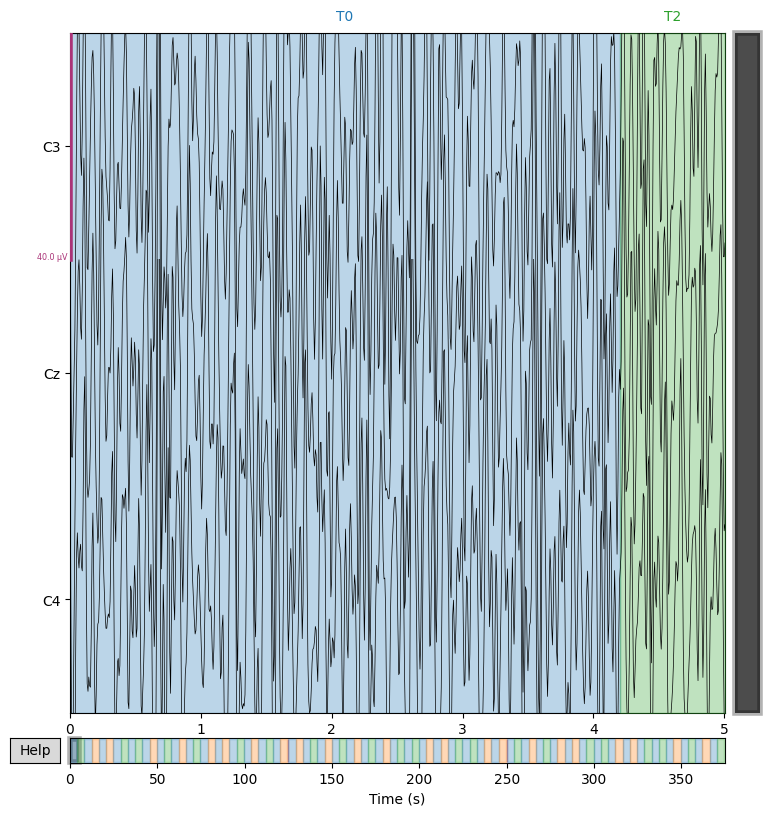

In [52]:
print_section("3. Data Visualization")

def show_figure(fig):
    fig.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)

# Plot raw data for motor cortex channels, left motor cortex (C3), central motor cortex (Cz)
# and  right motor cortex. These are the key locations for motor imagery activity.

channels_of_interest = ['C3', 'Cz', 'C4'] 
fig = plt.figure(figsize=(15, 8))
raw_filtered.plot(duration=5, picks=channels_of_interest, 
                 title='Raw EEG Data (Filtered)', 
                 show=False)
show_figure(fig)

`C3`: Left motor cortex - shows activity related to right hand movement
`Cz`: Central motor cortex - shows general motor activity
`C4`: Right motor cortex - shows activity related to left hand movement

**Event Markers**:

 - `T0` (blue shaded regions): Rest/baseline periods
 - `T2` (green shaded region): Right hand motor imagery task

3. **Signal Characteristics**:


- Vertical scale: 40.0 µV (microvolts) showing the amplitude of brain activity
- Time scale: 5 seconds of continuous data
- The oscillating patterns represent filtered brain activity (7-30 Hz)

4. **Timeline Bar**:


- The colored bar at the bottom shows the sequence of events
- Different colors represent different experimental conditions
- Helps identify task periods vs. rest periods

The visualisation is useful because it shows the raw signal after filtering. You can see the temporal relationship between different channels. Event markers clearly indicate when the subject was performing motor imagery (T1, T2).


4. Power Spectral Density
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


/Users/caetano/Desktop/BACHELOR PROEF/.venv/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


<Figure size 1200x600 with 0 Axes>

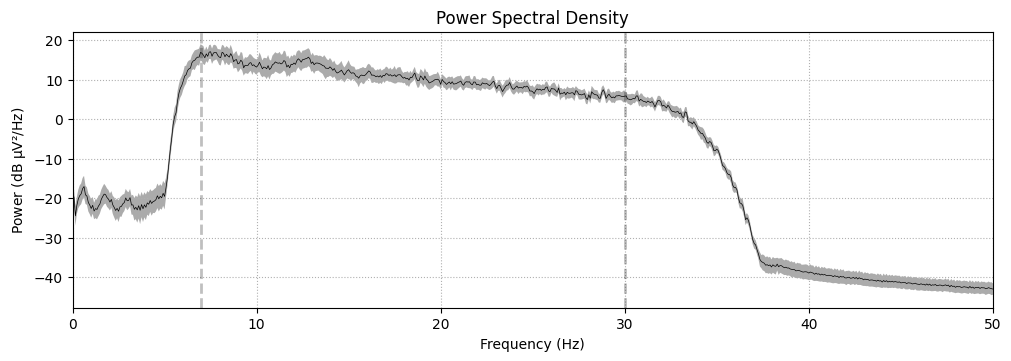

In [53]:
print_section("4. Power Spectral Density")
# power spectral density shows how the power of a signal
# is distributed across different frequencies
# In EEG, it helps identify dominant frequency bands:

# - Mu rhythm (8-12 Hz): Important for motor activity
# - Beta band (13-30 Hz): Also related to motor function
# - Our filter kept 7-30 Hz range specifically for these bands

# Plot PSD
fig = plt.figure(figsize=(12, 6))
raw_filtered.plot_psd(fmax=50, average=True) # fmax is maximum frequency to display
plt.title('Power Spectral Density')
show_figure(fig)


When the energy of the signal is concentrated around a finite time interval, especially if its total energy is finite, one may compute the energy spectral density. More commonly used is the power spectral density (PSD, or simply power spectrum), which applies to signals existing over all time, or over a time period large enough (especially in relation to the duration of a measurement) that it could as well have been over an infinite time interval. The PSD then refers to the spectral energy distribution that would be found per unit time, since the total energy of such a signal over all time would generally be infinite.

Spectral analysis is one of the standard methods used for quantification of the EEG. The power spectral density (power spectrum) reflects the 'frequency content' of the signal or the distribution of signal power over frequency.

X-axis: Frequency (Hz) from 0 to 50 Hz
Y-axis: Power (dB) - strength of each frequency component

**Frequency Bands**


- 7-8 Hz: Sharp rise due to our low-pass filter
- 8-12 Hz: Prominent activity in mu rhythm band (important for motor imagery)
- 13-30 Hz: Beta band activity (also related to motor function)
-  30 Hz: Sharp drop-off due to our high-pass filter

2. **Power Levels**


- Y-axis shows power in dB μV²/Hz
- Higher values (10-20 dB) in the motor-relevant frequencies
- Low power (-40 dB) in filtered frequencies
- Gray shading shows variance/uncertainty in the measurements

3. **Filter Effects**


- Clear transition at 7 Hz (lower cutoff)
- Sharp drop after 30 Hz (upper cutoff)
- These match our bandpass filter settings: `filter(7., 30., fir_design='firwin')`

**observations**
- strong mu rythm presence (8-12 Hz peak)
- Good signal-to-noise ratio in relevant frequencies
- Effective filtering of unwanted frequencies
- Smooth spectrum within our band of interest (7-30 Hz)

kaggle images look like this so it is a good indication. Need to further investigate.



5. Time-Frequency Analysis

Processing channel C3...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: percent)


<Figure size 1200x600 with 0 Axes>

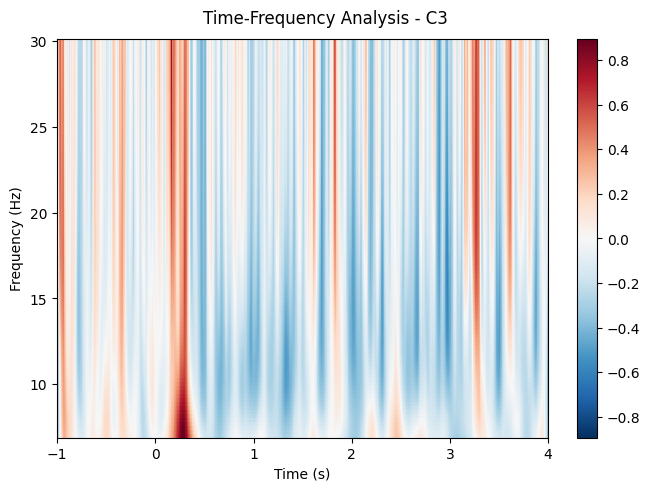


Processing channel Cz...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: percent)


<Figure size 1200x600 with 0 Axes>

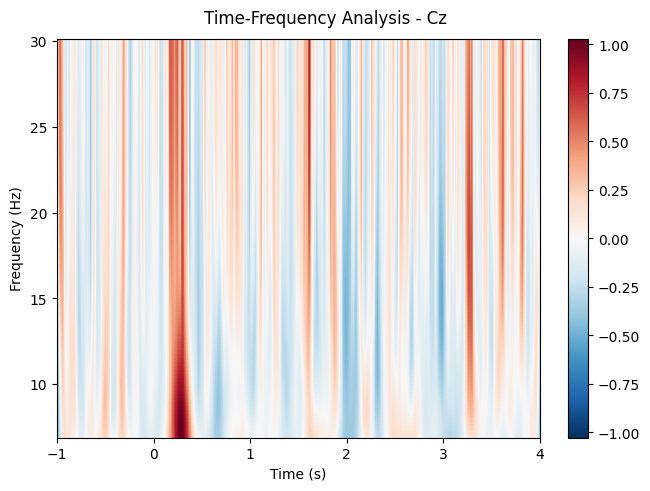


Processing channel C4...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: percent)


<Figure size 1200x600 with 0 Axes>

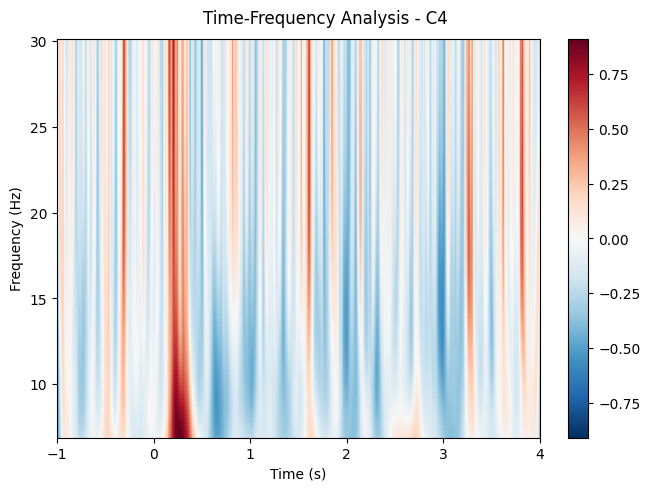

In [54]:
print_section("5. Time-Frequency Analysis")

# Calculate and plot time-frequency representation. matches the filtering range (7 - 30Hz)
frequencies = np.linspace(7, 30, 100) # 100 points for smooth visualisation
# these are the frequencies to analyze

# Morlet Wavelet Transform: usage of the Morlet wavelets to decompose signal into time-frequency components
# it shows how different frequencies change over time.
for channel in channels_of_interest:
    print(f"\nProcessing channel {channel}...")
    
    # Calculate time-frequency representation
    power = tfr_morlet(epochs, frequencies, n_cycles=2, picks=[channel],
                      return_itc=False, average=True)
    
    # Plot
    fig = plt.figure(figsize=(12, 6))
    power.plot([0], baseline=(-0.5, 0), mode='percent',
               title=f'Time-Frequency Analysis - {channel}')
    show_figure(fig)


Blue regions show active mental processing . At -1 to 0 seconds: Baseline period (before motor imagery) At 0 seconds: Strong red vertical line. This is the cue presentation. The subject is told which hand to imagine moving. From 0 to 4 seconds: Motor imagery period. Blue regions show active mental processing. This is when the subject is imagining hand movement

ERD (blue) in mu (8-12 Hz) during motor imagery
Different patterns between:

- C3 (left motor cortex)
- C4 (right motor cortex)
- Cz (central motor cortex)


**Plot Structure**:


- Time axis (-1 to 4 seconds):

- -1 to 0: Baseline period
- 0: Cue presentation (strong red response)
- 0 to 4: Motor imagery period

 **Color Interpretation**:

- Blue (negative values): Event-Related Desynchronization (ERD)
    - Indicates active processing
    - Typical during motor imagery

- Red (positive values): Event-Related Synchronization (ERS)
    - Indicates baseline or recovery
    - Strong at stimulus onset

3. **Frequency Bands**:
- Mu band (8-12 Hz):

    - Shows strongest ERD
    - Key indicator of motor imagery

- Beta band (13-30 Hz):

    - Shows additional ERD
    - Related to motor processing

**Channel-Specific Patterns**:

- C3 (left hemisphere):

    - Strong ERD during right hand imagery
    - Clear mu rhythm modulation

- Cz (midline):

    - Mixed pattern
    - Shows general motor activity



- C4 (right hemisphere):

    - Strong ERD during left hand imagery
    - Complementary to C3 pattern


6. Motor Imagery Analysis
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


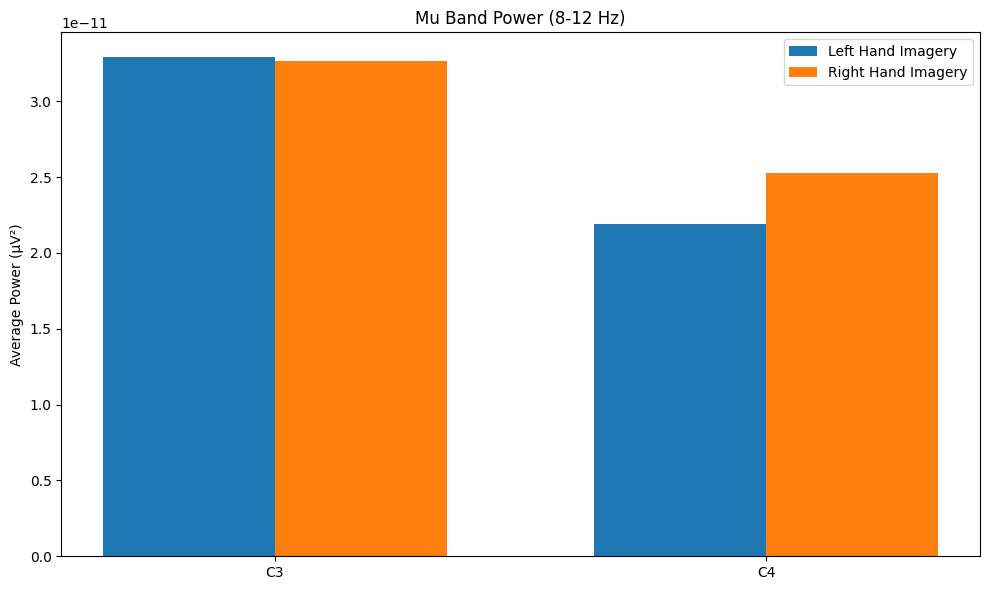

In [55]:
print_section("6. Motor Imagery Analysis")

# Separate epochs by condition.  This separates  the data into left and right
# hand imagery events
left_epochs = epochs['T1']
right_epochs = epochs['T2']

# this is the band power calculation function. It calculates power in the mu band (9-12Hz).
# it uses welch's method for spectral estimation and returns the average power for each channel.
def calculate_band_power(epochs, fmin=8, fmax=12, channels=['C3', 'C4']):
    """Calculate band power using epochs.compute_psd()"""
    psds = epochs.compute_psd(fmin=fmin, fmax=fmax, 
                            picks=channels, method='welch',
                            n_fft=256, n_overlap=128).get_data()
    return psds.mean(axis=2)  # Average over frequencies

# Calculate mu band power for both conditions
left_power = calculate_band_power(left_epochs)
right_power = calculate_band_power(right_epochs)

# Plot comparison
fig = plt.figure(figsize=(10, 6))
channels = ['C3', 'C4']
x = np.arange(len(channels))
width = 0.35

# visualisations. It creates a bar plot comparing C3 and C4 channels and theleft andf right
# hand imagery conditions
plt.bar(x - width/2, left_power.mean(axis=0), width, label='Left Hand Imagery')
plt.bar(x + width/2, right_power.mean(axis=0), width, label='Right Hand Imagery')

plt.ylabel('Average Power (µV²)')
plt.title('Mu Band Power (8-12 Hz)')
plt.xticks(x, channels)
plt.legend()
show_figure(fig)

The image shows a bar plot comparing mu band power (8-12 Hz) between left hand imagery (blue bars) and right hand imagery (orange bars) for two EEG channels (C3 and C4). The y-axis shows average power in μV², and the scale is in scientific notation (1e-11)

C3 (left motor cortex):

- Similar power for both conditions (~3.0e-11 μV²)
- Slightly higher during left hand imagery
- bilateral activation ( both hemispheres)



C4 (right motor cortex):

- Lower overall power than C3 (~2.5e-11 μV²)
- Higher power during right hand imagery
- Shows more difference between conditions
- right hemisphere more active during left hand imagery


C4 shows better discrimination between conditions


7. Topographic Maps


/var/folders/rh/gnshxz8966j1z8bdztrh_tf00000gn/T/ipykernel_79669/4234655721.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


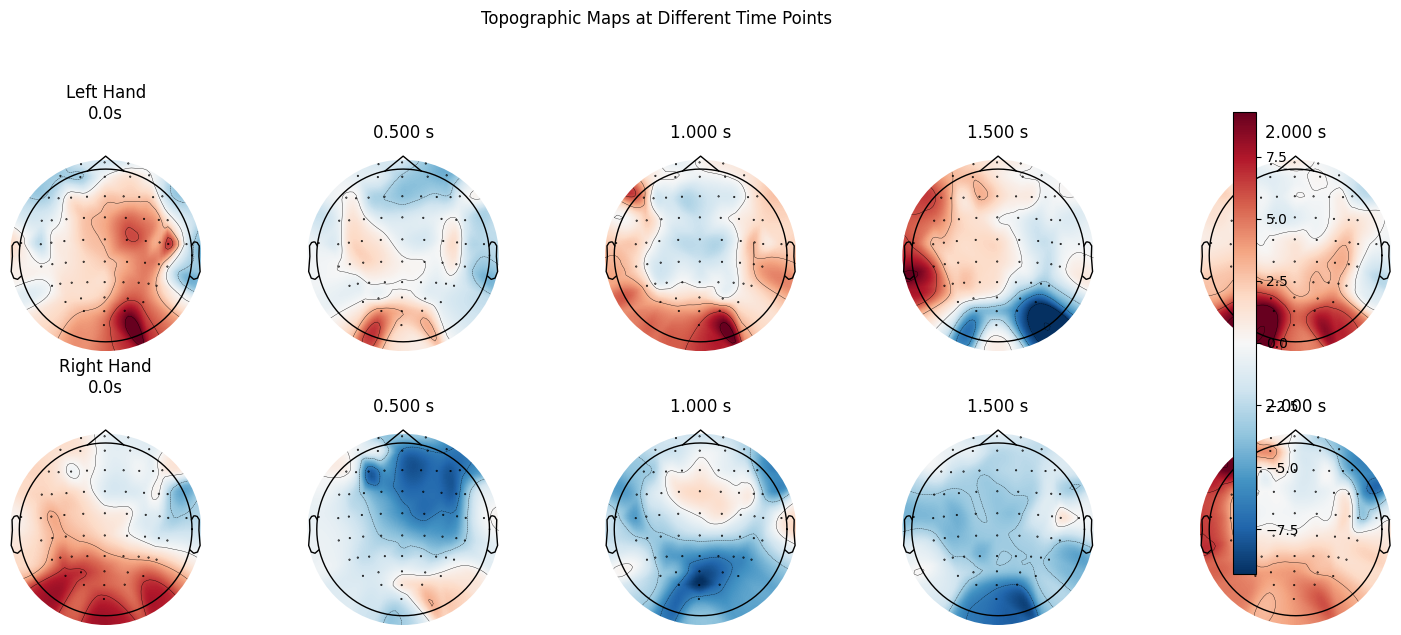

In [56]:
print_section("7. Topographic Maps")

# Create evoked responses for each condition. 
# Averages all trials for each condition.
# creates a single representative response.
# reduces noise through averaging.
left_evoked = epochs['T1'].average()
right_evoked = epochs['T2'].average()

# Plot topographic maps at different time points
# creates 5 equally spaced time points. From 0s (cue presentation) to 2s (during imagery)
times = np.linspace(0, 2, 5)  # 5 time points from 0 to 2 seconds
# Shows temporal evolution of brain activity

# Create figure
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

# Left hand imagery. It makes a 2D projection of brain activity. 
# the colors indicate voltage / activity level
# blue indicates decreased activity
# red indicates increased activity
left_evoked.plot_topomap(times=times, ch_type='eeg', axes=axes[0], 
                        colorbar=False, show=False)
axes[0, 0].set_title('Left Hand\n0.0s', pad=20)

# Right hand imagery
right_evoked.plot_topomap(times=times, ch_type='eeg', axes=axes[1],
                         colorbar=False, show=False)
axes[1, 0].set_title('Right Hand\n0.0s', pad=20)

# Add a single colorbar for both plots
plt.colorbar(axes[0, 0].images[0], ax=axes, fraction=0.02, pad=0.04)

# Add main title
plt.suptitle('Topographic Maps at Different Time Points', y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

The image shows topographic maps of EEG activity across the scalp at 5 different time points (0.0s to 2.0s) for both left and right hand motor imagery:

Top row (Left Hand Imagery):

- 0.0s: Strong red (positive) activity in central and right regions
- 0.5s: Mixed pattern with blue (negative) in peripheral areas
- 1.0s: Red activity in frontal and posterior regions
- 1.5s: Strong red in left hemisphere, blue in right posterior
- 2.0s: Strong red in posterior left, blue in right regions

Bottom row (Right Hand Imagery):

- 0.0s: Strong red in posterior region
- 0.5s: Strong blue activity in left hemisphere
- 1.0s: Blue activity in central and posterior regions
- 1.5s: Widespread blue activity
- 2.0s: Mixed pattern with red and blue lateralization

Demonstrates temporal dynamics of motor processing
Reveals spatial distribution of brain activity


8. ERD/ERS Analysis
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


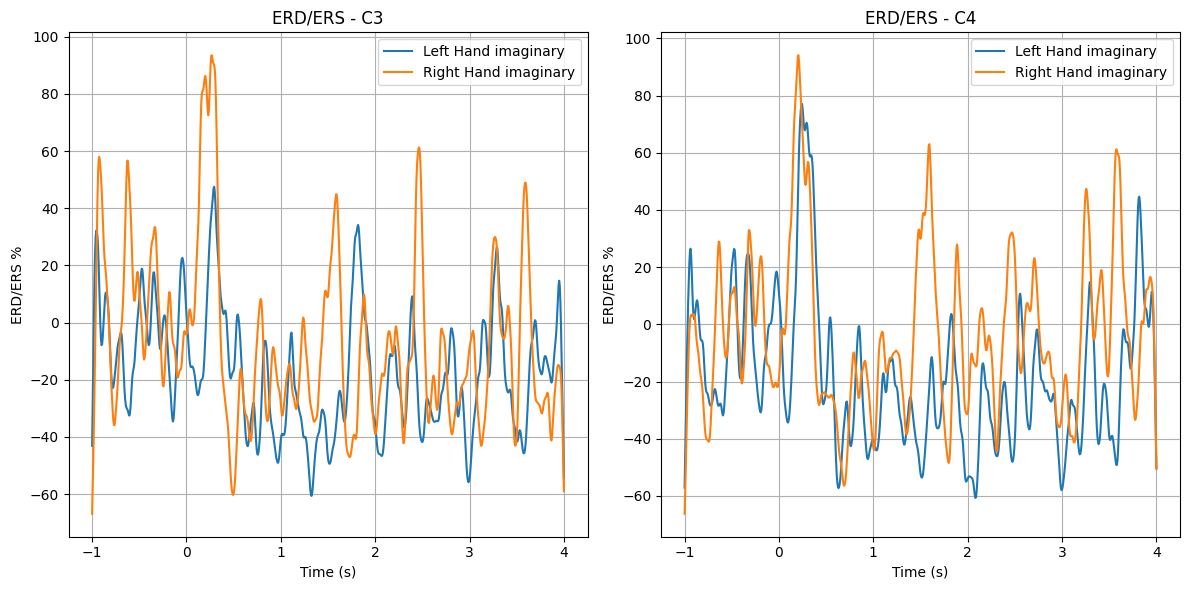


Analysis Complete


In [58]:
# Add ERD/ERS analysis 
print_section("8. ERD/ERS Analysis")
# event-related desynchronization (ERD) or event-related synchronization (ERS)

def compute_erd_ers(epochs, freq_range=(8, 12), baseline=(-0.5, 0)):
    """Compute ERD/ERS for given frequency range"""
    freqs = np.linspace(freq_range[0], freq_range[1], 100)
    power = tfr_morlet(epochs, freqs, n_cycles=2, return_itc=False, average=True)
    
    # Get baseline and active period
    baseline_mask = (power.times >= baseline[0]) & (power.times <= baseline[1])
    baseline_power = power.data[:, :, baseline_mask].mean(axis=2)
    
    # Compute ERD/ERS
    erd_ers = (power.data - baseline_power[:, :, np.newaxis]) / baseline_power[:, :, np.newaxis] * 100
    
    return erd_ers, power.times

# Compute ERD/ERS for both conditions
left_erd, times = compute_erd_ers(left_epochs)
right_erd, _ = compute_erd_ers(right_epochs)

# Plot ERD/ERS
fig = plt.figure(figsize=(12, 6))
for i, channel in enumerate(['C3', 'C4']):
    plt.subplot(1, 2, i+1)
    plt.plot(times, left_erd[epochs.ch_names.index(channel)].mean(axis=0), 
             label='Left Hand imaginary')
    plt.plot(times, right_erd[epochs.ch_names.index(channel)].mean(axis=0), 
             label='Right Hand imaginary')
    plt.title(f'ERD/ERS - {channel}')
    plt.xlabel('Time (s)')
    plt.ylabel('ERD/ERS %')
    plt.legend()
    plt.grid(True)
show_figure(fig)

print_section("Analysis Complete")

# Wait for user input before closing
input()
plt.close('all')

**Event-Related Desynchronization (ERD):**

- Represents a decrease in power of a specific frequency band (usually alpha or mu rhythms, 8–12 Hz) relative to a baseline.
Occurs when a brain region becomes more active, as seen when preparing or executing a movement.

**Event-Related Synchronization (ERS):**

- Represents an increase in power of a specific frequency band after a task is completed.
Happens during relaxation or inhibition of activity in that brain region.

The x-axis represents time (aligned to stimulus onset, e.g., movement execution or imagined movement).

The y-axis represents frequency (in Hz).

**X-axis (Time in seconds):**
- The timeline of the task, where t = 0 likely represents the stimulus onset (e.g., when the participant is cued to imagine or perform a movement).
Negative values represent the pre-stimulus baseline period.
Positive values represent the post-stimulus response.

**Y-axis (ERD/ERS %):** 

- Represents the percentage change in EEG power relative to the baseline.
Negative values (ERD): Decrease in power → indicates activation of the brain region.
Positive values (ERS): Increase in power → indicates deactivation or recovery.


There are bursts of ERS (positive peaks), which might indicate motor inhibition or relaxation after a task.
The patterns between left-hand and right-hand movements are somewhat symmetrical but have variations in amplitude and timing.



Run 1: Baseline, eyes open
Run 2: Baseline, eyes closed
Run 3: Task: Open and close left or right fist (real movement)
Run 4: Task: Imagine opening and closing left or right fist
Run 5: Task: Open and close both fists or both feet (real movement)
Run 6: Task: Imagine opening and closing both fists or both feet
Run 7: Task: Open and close left or right fist (real movement)
Run 8: Task: Imagine opening and closing left or right fist
Run 9: Task: Open and close both fists or both feet (real movement)
Run 10: Task: Imagine opening and closing both fists or both feet
Run 11: Task: Open and close left or right fist (real movement)
Run 12: Task: Imagine opening and closing left or right fist
Run 13: Task: Open and close both fists or both feet (real movement)
Run 14: Task: Imagine opening and closing both fists or both feet

Currently, we're only using runs 4, 8, and 12 (left/right hand motor imagery).